In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("/Users/anastasia/Downloads/customer_lifecycle_data_v2.csv")
df.info()
print(df.describe())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_ID          100 non-null    object 
 1   Onboarding_Date      100 non-null    object 
 2   Renewal_Date         100 non-null    object 
 3   Subscription_Type    100 non-null    object 
 4   Churn_Flag           100 non-null    int64  
 5   Product_Usage_Score  100 non-null    float64
 6   CSAT_Score           100 non-null    float64
 7   Support_Tickets      100 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.4+ KB
       Churn_Flag  Product_Usage_Score  CSAT_Score  Support_Tickets
count  100.000000           100.000000  100.000000       100.000000
mean     0.410000            71.165776    3.027366         2.930000
std      0.494311            13.858184    0.728543         1.765294
min      0.000000            39.622861    1.000000         0.00

,Customer_ID,Onboarding_Date,Renewal_Date,Subscription_Type,Churn_Flag,Product_Usage_Score,CSAT_Score,Support_Tickets
0,CUST0001,2022-01-02,2023-01-01,Premium,0,59.799629,4.697725,2
1,CUST0002,2022-01-09,2023-01-08,Enterprise,1,73.483805,3.825972,1
2,CUST0003,2022-01-16,2023-01-15,Premium,0,74.396087,1.784504,1
3,CUST0004,2022-01-23,2023-01-22,Premium,0,59.284729,2.612613,1
4,CUST0005,2022-01-30,2023-01-29,Basic,1,97.986618,4.013529,5


In [3]:
# Retention and churn rates by subscription type, on reflection - I want to reuse the first two dfs, but have updated them
renewed_df = df[df["Churn_Flag"]==0]
churned_df = df[df["Churn_Flag"]==1]
renewed_df = renewed_df.groupby("Subscription_Type").agg({
    "Customer_ID":"size"
}).rename(columns={
    "Customer_ID":"Total_Renewed_Customers"
})
churned_df = churned_df.groupby("Subscription_Type").agg({
    "Customer_ID":"size"
}).rename(columns={
    "Customer_ID":"Total_Churned_Customers"
})

retention_df = pd.merge(renewed_df, churned_df, on="Subscription_Type", how="outer").fillna(0)
display(retention_df)


,Total_Renewed_Customers,Total_Churned_Customers
Subscription_Type,,
Basic,20,14
Enterprise,12,6
Premium,27,21


In [4]:
retention_df["Total_Customers"] = retention_df["Total_Renewed_Customers"] + retention_df["Total_Churned_Customers"]
retention_df["Retention_Rate"] = retention_df["Total_Renewed_Customers"] / retention_df["Total_Customers"]
display(retention_df)

,Total_Renewed_Customers,Total_Churned_Customers,Total_Customers,Retention_Rate
Subscription_Type,,,,
Basic,20,14,34,0.588235
Enterprise,12,6,18,0.666667
Premium,27,21,48,0.562500


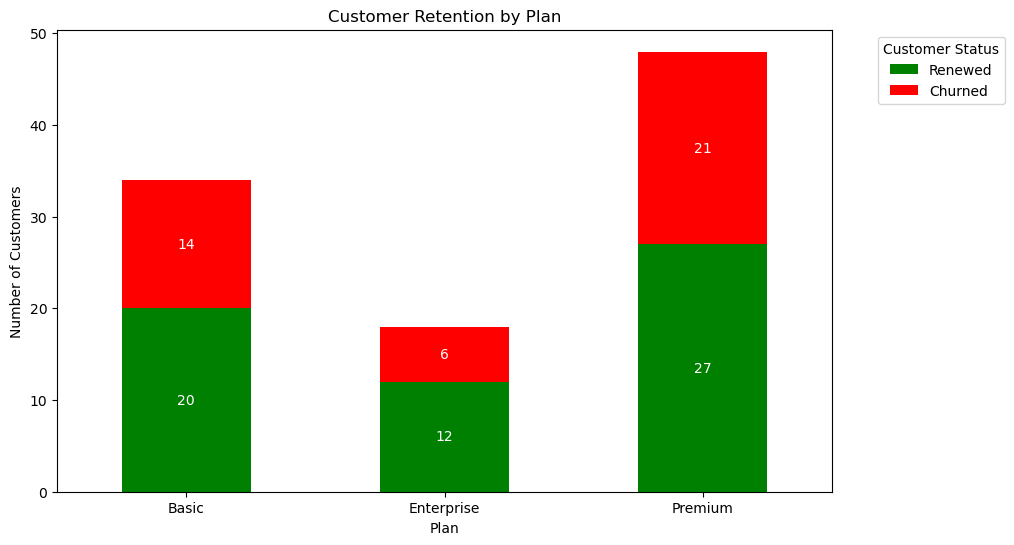

In [5]:
ax = retention_df[["Total_Renewed_Customers", "Total_Churned_Customers"]].plot(kind="bar", stacked=True, figsize=(10,6), color=["green", "red"])
plt.title("Customer Retention by Plan")
plt.xlabel("Plan")
plt.ylabel("Number of Customers")
plt.legend(["Renewed", "Churned"], title="Customer Status", bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=0)
for container in ax.containers:
    ax.bar_label(container, label_type="center", fontsize=10, color="white")

plt.show()

#this container code is new to me - I like it! Have done a lot of bar graphs recently. Should certainly add some practice for line etc.

In [6]:
df.head()

,Customer_ID,Onboarding_Date,Renewal_Date,Subscription_Type,Churn_Flag,Product_Usage_Score,CSAT_Score,Support_Tickets
0,CUST0001,2022-01-02,2023-01-01,Premium,0,59.799629,4.697725,2
1,CUST0002,2022-01-09,2023-01-08,Enterprise,1,73.483805,3.825972,1
2,CUST0003,2022-01-16,2023-01-15,Premium,0,74.396087,1.784504,1
3,CUST0004,2022-01-23,2023-01-22,Premium,0,59.284729,2.612613,1
4,CUST0005,2022-01-30,2023-01-29,Basic,1,97.986618,4.013529,5


In [7]:
renewed = df[df["Churn_Flag"]==0]
churned = df[df["Churn_Flag"]==1]
churned_scores = churned.groupby("Subscription_Type").agg({
    "CSAT_Score":"mean",
    "Product_Usage_Score":"mean"
}).rename(columns={
    "CSAT_Score":"Avg_Churned_CSAT",
    "Product_Usage_Score":"Avg_Churned_Product_Usage_Score"
})
renewed_scores = renewed.groupby("Subscription_Type").agg({
    "CSAT_Score":"mean",
    "Product_Usage_Score":"mean"
}).rename(columns={
    "CSAT_Score":"Avg_Renewed_CSAT",
    "Product_Usage_Score":"Avg_Renewed_Product_Usage_Score"
})
merged_scores = pd.merge(churned_scores, renewed_scores, on="Subscription_Type", how="outer")
display(merged_scores)

#data set is definitely weird - showing higher CSAT and PU for churned customers

,Avg_Churned_CSAT,Avg_Churned_Product_Usage_Score,Avg_Renewed_CSAT,Avg_Renewed_Product_Usage_Score
Subscription_Type,,,,
Basic,3.107828,77.746949,2.960817,69.837297
Enterprise,3.460736,77.733008,2.661880,66.200886
Premium,3.171647,73.890941,2.988857,67.365033


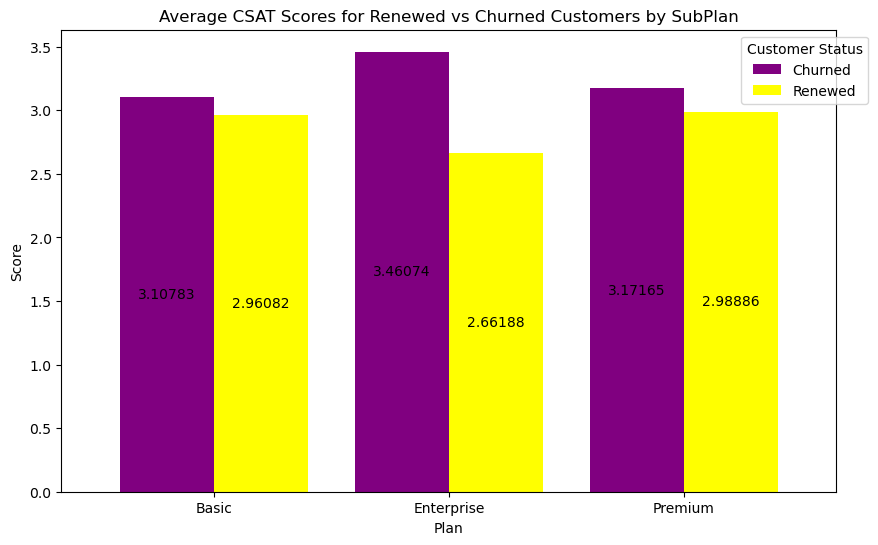

In [8]:
ax = merged_scores[["Avg_Churned_CSAT", "Avg_Renewed_CSAT"]].plot(kind="bar", figsize=(10,6), width=0.8, color=["purple", "yellow"])
plt.title("Average CSAT Scores for Renewed vs Churned Customers by SubPlan")
plt.xlabel("Plan")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(["Churned", "Renewed"], title="Customer Status", bbox_to_anchor=(1.05,1), loc="upper right")
for container in ax.containers:
    ax.bar_label(container, label_type="center", color="black")

plt.show()

In [9]:
merged_scores.head()

,Avg_Churned_CSAT,Avg_Churned_Product_Usage_Score,Avg_Renewed_CSAT,Avg_Renewed_Product_Usage_Score
Subscription_Type,,,,
Basic,3.107828,77.746949,2.960817,69.837297
Enterprise,3.460736,77.733008,2.661880,66.200886
Premium,3.171647,73.890941,2.988857,67.365033


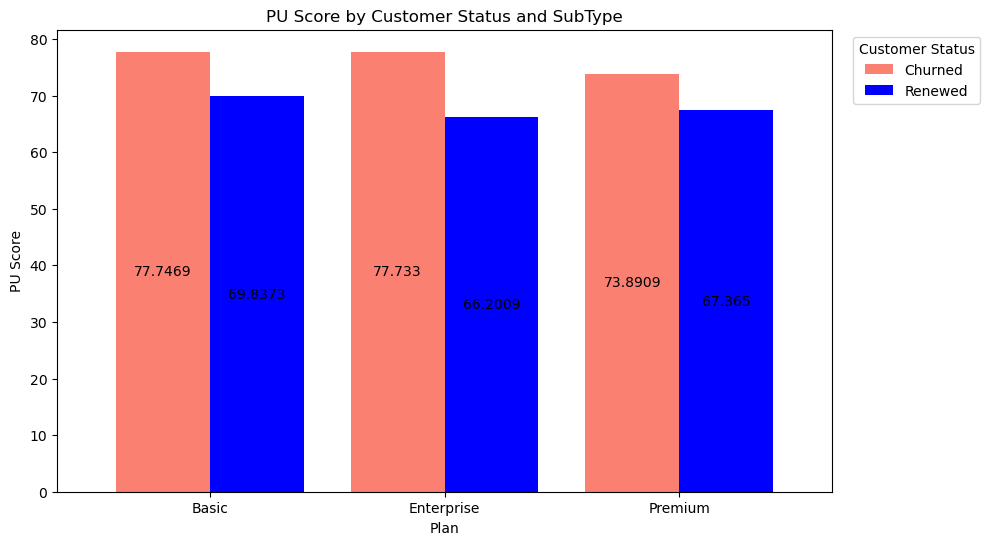

In [10]:
ax = merged_scores[["Avg_Churned_Product_Usage_Score", "Avg_Renewed_Product_Usage_Score"]].plot(kind="bar", figsize=(10,6), width=0.8, color=["salmon", "blue"])
plt.title("PU Score by Customer Status and SubType")
plt.xlabel("Plan")
plt.ylabel("PU Score")
plt.xticks(rotation=0)
plt.legend(["Churned", "Renewed"], title="Customer Status", bbox_to_anchor=(1.2,1), loc="upper right")
for container in ax.containers:
    ax.bar_label(container, label_type="center", color="black")

plt.show()

In [11]:
churned.head()

,Customer_ID,Onboarding_Date,Renewal_Date,Subscription_Type,Churn_Flag,Product_Usage_Score,CSAT_Score,Support_Tickets
1,CUST0002,2022-01-09,2023-01-08,Enterprise,1,73.483805,3.825972,1
4,CUST0005,2022-01-30,2023-01-29,Basic,1,97.986618,4.013529,5
7,CUST0008,2022-02-20,2023-02-19,Enterprise,1,79.848304,3.619707,3
12,CUST0013,2022-03-27,2023-03-26,Enterprise,1,84.450642,2.797945,1
13,CUST0014,2022-04-03,2023-04-02,Basic,1,76.191714,2.001773,7


In [12]:
churned_tickets = churned.groupby("Subscription_Type").agg({
    "Support_Tickets":"mean"
}).rename(columns={
    "Support_Tickets":"Average_Support_Tickets_Churned_Customers"
})
renewed_tickets = renewed.groupby("Subscription_Type").agg({
    "Support_Tickets":"mean"
}).rename(columns={
    "Support_Tickets":"Average_Support_Tickets_Renewed_Customers"
})
merged_tickets = pd.merge(churned_tickets, renewed_tickets, on="Subscription_Type", how="outer")
display(merged_tickets)

,Average_Support_Tickets_Churned_Customers,Average_Support_Tickets_Renewed_Customers
Subscription_Type,,
Basic,2.857143,3.100000
Enterprise,2.333333,2.833333
Premium,3.190476,2.814815


In [13]:
df["Onboarding_Date"] = pd.to_datetime(df["Onboarding_Date"])
df["Renewal_Date"] = pd.to_datetime(df["Renewal_Date"])
df.head()

,Customer_ID,Onboarding_Date,Renewal_Date,Subscription_Type,Churn_Flag,Product_Usage_Score,CSAT_Score,Support_Tickets
0,CUST0001,2022-01-02,2023-01-01,Premium,0,59.799629,4.697725,2
1,CUST0002,2022-01-09,2023-01-08,Enterprise,1,73.483805,3.825972,1
2,CUST0003,2022-01-16,2023-01-15,Premium,0,74.396087,1.784504,1
3,CUST0004,2022-01-23,2023-01-22,Premium,0,59.284729,2.612613,1
4,CUST0005,2022-01-30,2023-01-29,Basic,1,97.986618,4.013529,5


In [17]:
df["Onboarding_Month"] = df["Onboarding_Date"].dt.to_period("M")
df["Renewal_Month"] = df["Renewal_Date"].dt.to_period("M")
df.head()

,Customer_ID,Onboarding_Date,Renewal_Date,Subscription_Type,Churn_Flag,Product_Usage_Score,CSAT_Score,Support_Tickets,Onboarding_Month,Renewal_Month
0,CUST0001,2022-01-02,2023-01-01,Premium,0,59.799629,4.697725,2,2022-01,2023-01
1,CUST0002,2022-01-09,2023-01-08,Enterprise,1,73.483805,3.825972,1,2022-01,2023-01
2,CUST0003,2022-01-16,2023-01-15,Premium,0,74.396087,1.784504,1,2022-01,2023-01
3,CUST0004,2022-01-23,2023-01-22,Premium,0,59.284729,2.612613,1,2022-01,2023-01
4,CUST0005,2022-01-30,2023-01-29,Basic,1,97.986618,4.013529,5,2022-01,2023-01


In [18]:
monthly_churn = df.groupby(["Renewal_Month", "Churn_Flag"])["Customer_ID"].size().unstack().fillna(0)
monthly_churn.columns = ["Renewed_Customers", "Churned_Customers"]
display(monthly_churn)

,Renewed_Customers,Churned_Customers
Renewal_Month,,
2023-01,3.0,2.0
2023-02,3.0,1.0
2023-03,3.0,1.0
2023-04,1.0,4.0
2023-05,1.0,3.0
2023-06,4.0,0.0
2023-07,3.0,2.0
2023-08,3.0,1.0
2023-09,3.0,1.0


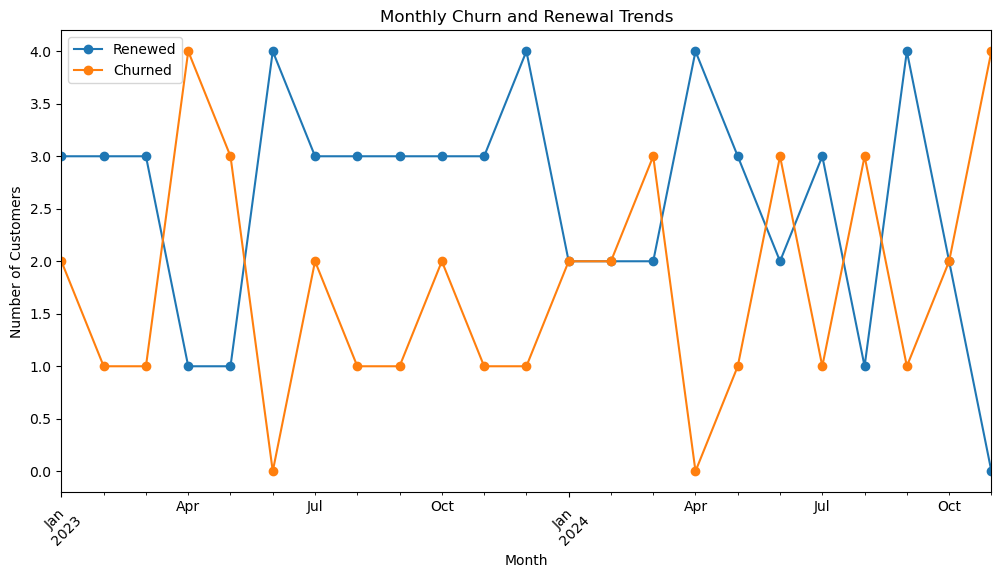

In [22]:
monthly_churn.plot(kind="line", figsize=(12, 6), marker="o")
plt.title("Monthly Churn and Renewal Trends")
plt.xlabel("Month")
plt.ylabel("Number of Customers")
plt.legend(["Renewed", "Churned"])
plt.xticks(rotation=45)
plt.show()

In [33]:
df.head()

,Customer_ID,Onboarding_Date,Renewal_Date,Subscription_Type,Churn_Flag,Product_Usage_Score,CSAT_Score,Support_Tickets,Onboarding_Month,Renewal_Month
0,CUST0001,2022-01-02,2023-01-01,Premium,0,59.799629,4.697725,2,2022-01,2023-01
1,CUST0002,2022-01-09,2023-01-08,Enterprise,1,73.483805,3.825972,1,2022-01,2023-01
2,CUST0003,2022-01-16,2023-01-15,Premium,0,74.396087,1.784504,1,2022-01,2023-01
3,CUST0004,2022-01-23,2023-01-22,Premium,0,59.284729,2.612613,1,2022-01,2023-01
4,CUST0005,2022-01-30,2023-01-29,Basic,1,97.986618,4.013529,5,2022-01,2023-01


In [35]:
df["Engagement_Level"] = pd.cut(
    df["Product_Usage_Score"],
    bins=[0,50,75,100],
    labels=["low", "medium", "high"]
)
df.head()

,Customer_ID,Onboarding_Date,Renewal_Date,Subscription_Type,Churn_Flag,Product_Usage_Score,CSAT_Score,Support_Tickets,Onboarding_Month,Renewal_Month,Engagement_Level
0,CUST0001,2022-01-02,2023-01-01,Premium,0,59.799629,4.697725,2,2022-01,2023-01,medium
1,CUST0002,2022-01-09,2023-01-08,Enterprise,1,73.483805,3.825972,1,2022-01,2023-01,medium
2,CUST0003,2022-01-16,2023-01-15,Premium,0,74.396087,1.784504,1,2022-01,2023-01,medium
3,CUST0004,2022-01-23,2023-01-22,Premium,0,59.284729,2.612613,1,2022-01,2023-01,medium
4,CUST0005,2022-01-30,2023-01-29,Basic,1,97.986618,4.013529,5,2022-01,2023-01,high


In [37]:
engagement_churn = df.groupby("Engagement_Level")["Churn_Flag"].mean()
display(engagement_churn)

/var/folders/68/p6tbj3yj42n58fkdzr4c1br00000gn/T/ipykernel_37513/3015018795.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_churn = df.groupby("Engagement_Level")["Churn_Flag"].mean()


Engagement_Level
low       0.200000
medium    0.333333
high      0.522727
Name: Churn_Flag, dtype: float64

In [39]:
engagement_satisfaction = df.groupby("Engagement_Level")["CSAT_Score"].mean()
display(engagement_satisfaction)

/var/folders/68/p6tbj3yj42n58fkdzr4c1br00000gn/T/ipykernel_37513/3440301965.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_satisfaction = df.groupby("Engagement_Level")["CSAT_Score"].mean()


Engagement_Level
low       3.194951
medium    3.107829
high      2.915059
Name: CSAT_Score, dtype: float64